In [5]:
import spacy
from spacy import displacy
from lambeq import AtomicType, IQPAnsatz
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from matplotlib import rcParams

n, s = Ty('n'), Ty('s')
# nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("ja_ginza")
# nlp = spacy.load("en_core_web_lg")
# nlp = spacy.load("en_core_web_trf")
# モデルの大きさによって解析精度に差あり

rcParams['font.family'] = 'Hiragino Sans'  # macOS標準のヒラギノ角ゴ
rcParams['axes.unicode_minus'] = False     # マイナス記号が文字化けしないように

In [25]:
sentence = "冬は寒い。"
# 思っていたより成果が出なくて残念です。
doc = nlp(sentence)
displacy.serve(doc, style='dep', port=5001)

for token in doc:
    print(token.text+'<-'+token.head.text,token.dep_)


Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.
冬<-寒い obl
は<-冬 case
寒い<-寒い ROOT
。<-寒い punct


In [ ]:
"""# 型の割り当て
def assign_types(sentence):
    doc = nlp(sentence)
    pregroup_types = {}
    dependencies = []

    # 文末記号を除いてトークン化
    tokens = [token.text for token in doc if token.text not in ['.', '。', '!', '！', '?', '？']]

    # 各トークンに型を割り振る
    for i, token in enumerate(doc):
        if token.text in ['.', '。', '!', '！', '?', '？']:
            break  # 文末に達したらループ終了

        token_key = f"{token.text}_{i}"
        head_index = tokens.index(token.head.text) if token.head.text in tokens else -1
        head_key = f"{token.head.text}_{head_index}" if head_index != -1 else None

        # 依存関係の記録
        if head_key:
            dependencies.append((token_key, head_key))

        # 型割り当て
        if token.dep_ == 'ROOT':
            pregroup_types[token_key] = s
        else:
            pregroup_types[token_key] = n

    print("=== Dependencies ===")
    print(dependencies)

    # 依存関係による型の調整（語順に基づいて左・右随伴を付与）
    for dep_from, dep_to in dependencies:
        if dep_from == dep_to or dep_to not in pregroup_types or dep_from not in pregroup_types:
            continue

        idx1 = int(dep_from.split('_')[-1])
        idx2 = int(dep_to.split('_')[-1])

        if idx1 < idx2:
            pregroup_types[dep_to] = n.r @ pregroup_types[dep_to]
        else:
            pregroup_types[dep_to] = pregroup_types[dep_to] @ n.l

    print("=== Final pregroup types ===")
    print(pregroup_types)

    return pregroup_types


In [7]:
def assign_types(sentence):
    doc = nlp(sentence)
    pregroup_types = {}
    dependencies = []

    # 文末記号を除いてトークン化
    valid_tokens = [token for token in doc if token.text not in ['.', '。', '!', '！', '?', '？']]

    for token in valid_tokens:
        token_key = f"{token.text}_{token.i}"  # ← spaCyの固有インデックスを使用
        head_key = f"{token.head.text}_{token.head.i}" if token.head.text in [t.text for t in valid_tokens] else None

        # 型割り当て
        if token.dep_ == 'ROOT':
            pregroup_types[token_key] = s
        else:
            pregroup_types[token_key] = n

        if head_key:
            dependencies.append((token_key, head_key))

    # 依存関係による型調整
    for dep_from, dep_to in dependencies:
        if dep_from == dep_to or dep_to not in pregroup_types or dep_from not in pregroup_types:
            continue

        idx1 = int(dep_from.split('_')[-1])
        idx2 = int(dep_to.split('_')[-1])

        if idx1 < idx2:
            pregroup_types[dep_to] = n.r @ pregroup_types[dep_to]
        else:
            pregroup_types[dep_to] = pregroup_types[dep_to] @ n.l

    return pregroup_types

In [8]:
# Diagram作成
def create_diagram(sentence):
    pregroup_types = assign_types(sentence)

    words = []
    types = Ty()

    # ここでインデックスを除去して、lambeqが単語単位でパラメータを共有できるようにする
    for word_key, typ in pregroup_types.items():
        base_word = word_key.split('_')[0]  # "book_0" → "book"
        words.append(Word(base_word, typ))
        types @= typ

    # すべてのWordをテンソル積で連結
    diagram = Id().tensor(*words)

    # Cups適用
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1

    return diagram

In [ ]:
"""# diagram作成
def create_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # カップ構造を作る
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

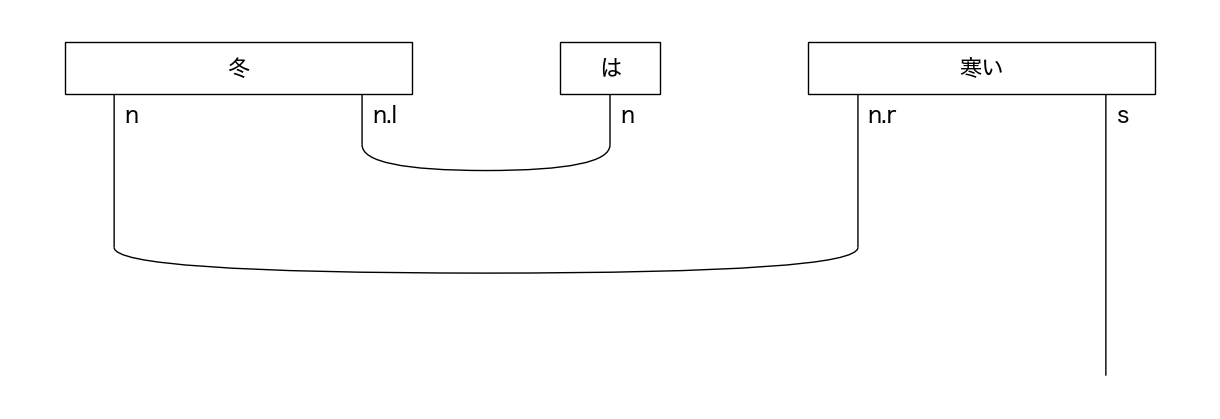

In [47]:
sentence = "冬は寒い。"
diagram = create_diagram(sentence)
draw(diagram, figsize=(12, 4), fontsize=16)

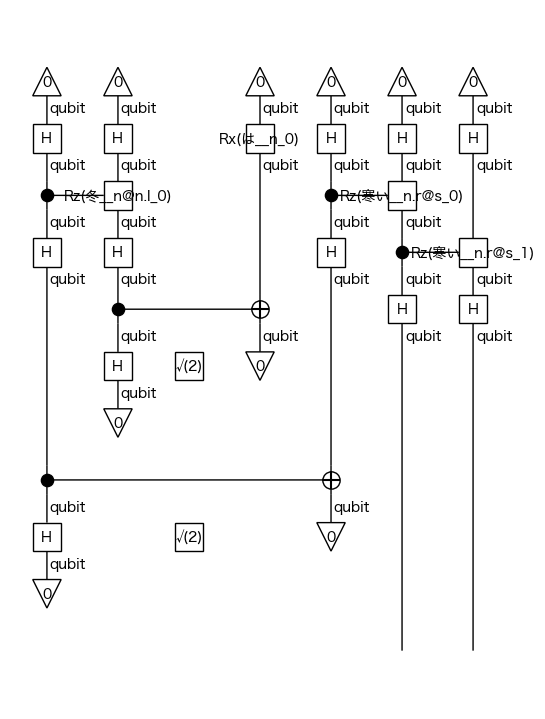

In [48]:
# 量子回路設計
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 2}, n_layers=1, n_single_qubit_params=1)
circuit = ansatz(diagram)
circuit.draw(figsize=(5, 7))